<a href="https://colab.research.google.com/github/lazysjb/camelyon16/blob/master/Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelling 

## Get Moduels and Data

In [6]:
# install tensorflow 
#!pip install tensorflow
#!pip install Keras --upgrade



/bin/bash: Keras: command not found


In [8]:
# import libraries
from google.colab import drive
import os
import keras
import zipfile
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [9]:
# mount drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [10]:
# working directory
path = 'gdrive/My Drive/STUDY/Columbia/Term 2/Applied Deep Learning/Project/Final Training Data/shared_files'
os.listdir(path)


['train_val_test_split.json',
 'tumor_img_meta_info.json',
 'zoom_5_60_60_partition.zip',
 'zoom_5_60_60_partition',
 'zoom_2_200_200_partition.zip',
 'bounding_boxes',
 'all_info_0.4_grayscale_tol_with_roi.json',
 'zoom_1_256_256_partition.zip',
 'zoom_1_256_256_partition_truncated.zip']

In [0]:
# unzip data folders to root dir
zf = zipfile.ZipFile(os.path.join(path, 'zoom_5_60_60_partition.zip'))
zf.extractall()


## Preprocess Data

In [12]:
!ls zoom_5_60_60_partition/train

mask  slide


In [13]:
# get metadata
df_meta_greyscale = pd.read_json('zoom_5_60_60_partition/meta/all_info_0.4_grayscale_tol.json')
df_meta_greyscale.head()

,file_name,img_id,include,label,non_gray_ratio,type
0,tumor_slide_001_split_25_26.png,1,0,0,0.000000,val
1,tumor_slide_001_split_25_32.png,1,0,0,0.000000,val
2,tumor_slide_001_split_77_12.png,1,0,0,0.043333,val
3,tumor_slide_001_split_31_47.png,1,0,0,0.000556,val
4,tumor_slide_001_split_79_17.png,1,0,0,0.031389,val


In [0]:
# cast target as string (keras needs strings)
%%capture
df_meta_greyscale.loc[:, 'label'] = df_meta_greyscale.label.astype('str')

In [15]:
# get patches with sufficient tissue
df_train = df_meta_greyscale.loc[(df_meta_greyscale.include == 1) & (df_meta_greyscale['type'] == 'train'),:]

df_train.head()

,file_name,img_id,include,label,non_gray_ratio,type
11567,tumor_slide_005_split_90_25.png,5,1,0,0.476667,train
11582,tumor_slide_005_split_87_15.png,5,1,0,0.966667,train
11608,tumor_slide_005_split_89_10.png,5,1,0,0.805278,train
11618,tumor_slide_005_split_89_11.png,5,1,0,0.978889,train
11627,tumor_slide_005_split_80_21.png,5,1,0,0.822222,train


In [16]:
# get patches with sufficient tissue
df_val = df_meta_greyscale.loc[(df_meta_greyscale.include == 1) & (df_meta_greyscale['type'] == 'val'),:]

df_val.head()

,file_name,img_id,include,label,non_gray_ratio,type
5,tumor_slide_001_split_70_33.png,1,1,0,0.975833,val
9,tumor_slide_001_split_70_27.png,1,1,0,0.985556,val
28,tumor_slide_001_split_0_46.png,1,1,0,0.666944,val
45,tumor_slide_001_split_60_22.png,1,1,0,0.960278,val
52,tumor_slide_001_split_41_13.png,1,1,0,0.997500,val


In [17]:
# get patches with sufficient tissue
df_test = df_meta_greyscale.loc[(df_meta_greyscale.include == 1) & (df_meta_greyscale['type'] == 'test'),:]

df_test.head()

,file_name,img_id,include,label,non_gray_ratio,type
5777,tumor_slide_002_split_52_16.png,2,1,0,0.422500,test
5783,tumor_slide_002_split_55_23.png,2,1,0,0.912500,test
5803,tumor_slide_002_split_63_36.png,2,1,0,0.886389,test
5854,tumor_slide_002_split_61_33.png,2,1,0,0.938333,test
5903,tumor_slide_002_split_50_13.png,2,1,0,0.949444,test


In [18]:
# downsampled df 
df_train['label'].value_counts()


0    3967
1     695
Name: label, dtype: int64

In [0]:
df_down = pd.concat([df_train[df_train['label'] == '0'].sample(1000), df_train[df_train['label'] == '1']], axis = 0)

In [20]:
df_down.head()

,file_name,img_id,include,label,non_gray_ratio,type
84760,tumor_slide_101_split_31_24.png,101,1,0,0.750000,train
68732,tumor_slide_075_split_9_38.png,75,1,0,0.736667,train
69141,tumor_slide_075_split_13_36.png,75,1,0,0.596944,train
79471,tumor_slide_094_split_35_20.png,94,1,0,0.555278,train
81476,tumor_slide_096_split_10_26.png,96,1,0,0.988056,train


In [0]:
df_up = pd.concat([df_train, df_train[df_train['label'] == '1'].sample(3500, replace=True)], axis = 0)

In [22]:
df_up.label.value_counts()

1    4195
0    3967
Name: label, dtype: int64

In [23]:
# specify image data generator with augmentation
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                         rotation_range=180,
                                                         horizontal_flip=True,
                                                         vertical_flip = True)

# datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# read data from the train directory
train_generator = datagen.flow_from_dataframe(dataframe = df_up, 
                                              directory = 'zoom_5_60_60_partition/train/slide',
                                              x_col = 'file_name', 
                                              y_col='label',
                                              class_mode='binary', 
                                              target_size=(60,60), 
                                              batch_size=32,
                                              drop_duplicates=False)



Found 8162 images belonging to 2 classes.


In [24]:
len(train_generator)

256

In [25]:
# specify image data generator with augmentation
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# read data from the train directory
val_generator = datagen.flow_from_dataframe(dataframe = df_val, 
                                              directory = 'zoom_5_60_60_partition/val/slide',
                                              x_col = 'file_name', 
                                              y_col='label',
                                              class_mode='binary', 
                                              target_size=(60,60), 
                                              batch_size=32)



Found 1283 images belonging to 2 classes.


In [26]:
len(val_generator)

41

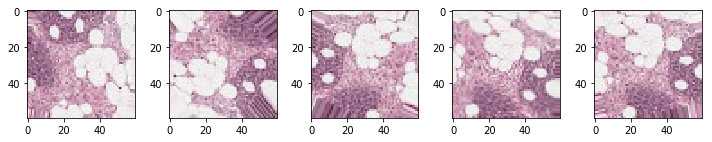

In [27]:
# plot augmented images
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(10,10))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.grid(False)
        ax.imshow(img)
    plt.tight_layout()
    plt.show()
    
    
augmented_images = [train_generator[0][0][0] for i in range(5)]

plotImages(augmented_images)

##  Baseline model

In [37]:
# specify model architecture
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(60, 60, 3)))
model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
#model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu'))
#model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Flatten())
#model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))


Instructions for updating:
Colocations handled automatically by placer.


In [38]:
# compile model
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# print model architecture
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 58, 58, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 54, 54, 256)       295168    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 256)       0         
_________________________________________________________________
flatten (Flatten)            (None, 186624)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               23888000  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total para

In [39]:
EPOCHS = 20

history_1 = model.fit_generator(train_generator,
                   epochs = EPOCHS,
                   validation_data = val_generator,
                   verbose=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
256/256 [==============================] - 22s 84ms/step - loss: 0.6145 - acc: 0.6971 - val_loss: 0.5171 - val_acc: 0.7553
Epoch 2/20
256/256 [==============================] - 18s 69ms/step - loss: 0.4781 - acc: 0.7623 - val_loss: 0.4810 - val_acc: 0.8480
Epoch 3/20
256/256 [==============================] - 19s 73ms/step - loss: 0.4573 - acc: 0.7719 - val_loss: 0.3819 - val_acc: 0.8807
Epoch 4/20
256/256 [==============================] - 18s 69ms/step - loss: 0.4522 - acc: 0.7757 - val_loss: 0.3738 - val_acc: 0.8807
Epoch 5/20
256/256 [==============================] - 18s 70ms/step - loss: 0.4263 - acc: 0.7931 - val_loss: 0.4512 - val_acc: 0.8807
Epoch 6/20
256/256 [==============================] - 18s 70ms/step - loss: 0.4276 - acc: 0.7928 - val_loss: 0.4895 - val_acc: 0.8613
Epoch 7/20
256/256 [==============================] - 19s 74ms/step - loss: 0.3987 - acc: 0.8036 - val_loss: 0.4407 - val_acc: 0.8807
Epoch 8/20
256

## Adjusted class weights model

In [47]:
# try again with balanced class weights
import sklearn
import numpy as np

y_train = df_train['label']

class_weights = sklearn.utils.class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

class_weights

array([0.58759768, 3.35395683])

In [48]:
# create class weights dictionary
cw = dict(zip([0,1], class_weights))
# doesnt work for some reason 
cw

{0: 0.587597680867154, 1: 3.353956834532374}

In [0]:
# specify model architecture
model_2 = tf.keras.Sequential()

model_2.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(60, 60, 3)))
model_2.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model_2.add(tf.keras.layers.MaxPooling2D((2, 2)))
model_2.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model_2.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model_2.add(tf.keras.layers.MaxPooling2D((2, 2)))

model_2.add(tf.keras.layers.Flatten())
model_2.add(tf.keras.layers.Flatten(input_shape = (60, 60, 3)))
model_2.add(tf.keras.layers.Dense(256, activation='relu'))
model_2.add(tf.keras.layers.Dense(128, activation='tanh'))
model_2.add(tf.keras.layers.Dense(1, activation='sigmoid'))


In [50]:
# recompile model
model_2.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

model_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 58, 58, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 56, 56, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 64)        36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 9216)              0         
__________

In [51]:
EPOCHS = 40

history_2 = model_2.fit_generator(train_generator,
                   epochs = EPOCHS,
                   validation_data = val_generator,
                   class_weight = class_weights,
                   shuffle=True)

Epoch 1/40
256/256 [==============================] - 16s 61ms/step - loss: 0.6417 - acc: 0.6007 - val_loss: 0.4047 - val_acc: 0.8807
Epoch 2/40
256/256 [==============================] - 16s 62ms/step - loss: 0.4836 - acc: 0.7635 - val_loss: 0.3819 - val_acc: 0.8807
Epoch 3/40
256/256 [==============================] - 15s 59ms/step - loss: 0.4575 - acc: 0.7765 - val_loss: 0.4504 - val_acc: 0.8691
Epoch 4/40
256/256 [==============================] - 16s 63ms/step - loss: 0.4310 - acc: 0.7904 - val_loss: 0.3667 - val_acc: 0.8807
Epoch 5/40
256/256 [==============================] - 15s 60ms/step - loss: 0.4260 - acc: 0.7937 - val_loss: 0.3291 - val_acc: 0.8807
Epoch 6/40
256/256 [==============================] - 15s 59ms/step - loss: 0.4070 - acc: 0.8051 - val_loss: 0.3884 - val_acc: 0.8714
Epoch 7/40
256/256 [==============================] - 15s 59ms/step - loss: 0.4011 - acc: 0.8127 - val_loss: 0.3195 - val_acc: 0.8807
Epoch 8/40
256/256 [==============================] - 15s 59ms

In [0]:
model.predict(val_generator)

array([[0.2554441 ],
       [0.90633047],
       [0.2586465 ],
       ...,
       [0.09441949],
       [0.0263592 ],
       [0.3309168 ]], dtype=float32)

In [0]:
y_val = df_val['label']
y_val.value_counts(normalize=True)

0    0.880748
1    0.119252
Name: label, dtype: float64

## Use Transfer Learning

In [0]:
from tensorflow.keras.applications import VGG16

In [0]:
conv_base_1 = VGG16(weights='imagenet',
                    include_top=False, 
                    input_shape=(60, 60, 3))


In [37]:
conv_base_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 60, 60, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 60, 60, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 60, 60, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 30, 30, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 30, 30, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 30, 30, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 15, 15, 128)       0         
__________

In [0]:
# instantiate model
model_1 = tf.keras.models.Sequential()

model_1.add(conv_base_1)
model_1.add(tf.keras.layers.Flatten())
model_1.add(tf.keras.layers.Dense(512, activation='relu'))
model_1.add(tf.keras.layers.Dense(256, activation='relu'))
model_1.add(tf.keras.layers.Dense(1, activation='sigmoid'))

conv_base_1.trainable = False

model_1.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [45]:
model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_7 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 257       
Total params: 15,108,929
Trainable params: 394,241
Non-trainable params: 14,714,688
_________________________________________________________________


In [46]:
model_1.fit_generator(train_generator,
                   epochs = 20,
                   validation_data = val_generator,
                   verbose=1)

Epoch 1/20
256/256 [==============================] - 20s 76ms/step - loss: 0.5748 - acc: 0.6925 - val_loss: 0.5900 - val_acc: 0.6399
Epoch 2/20
256/256 [==============================] - 15s 60ms/step - loss: 0.5027 - acc: 0.7458 - val_loss: 0.3532 - val_acc: 0.8683
Epoch 3/20
256/256 [==============================] - 17s 65ms/step - loss: 0.4770 - acc: 0.7585 - val_loss: 0.5914 - val_acc: 0.6921
Epoch 4/20
256/256 [==============================] - 16s 61ms/step - loss: 0.4774 - acc: 0.7618 - val_loss: 0.4964 - val_acc: 0.7607
Epoch 5/20
256/256 [==============================] - 15s 60ms/step - loss: 0.4674 - acc: 0.7634 - val_loss: 0.4580 - val_acc: 0.7903
Epoch 6/20
256/256 [==============================] - 16s 61ms/step - loss: 0.4471 - acc: 0.7771 - val_loss: 0.3899 - val_acc: 0.8527
Epoch 7/20
256/256 [==============================] - 15s 60ms/step - loss: 0.4418 - acc: 0.7835 - val_loss: 0.3921 - val_acc: 0.8581
Epoch 8/20
256/256 [==============================] - 16s 63ms

## Grid search model

In [0]:
def make_model(units_1, units_2, reg_str_1, reg_str_2):
  
  conv_base_1 = VGG16(weights='imagenet',
                    include_top=False, 
                    input_shape=(60, 60, 3))
  
  model = tf.keras.models.Sequential()
  
  model_1.add(conv_base_1)
  
  model_1.add(tf.keras.layers.Flatten())
  
  model_1.add(tf.keras.layers.Dense(units_1, activation='relu',
                                   kernel_regularizer=keras.regularizers.l2(l= reg_str_1)))
  
  model_1.add(tf.keras.layers.Dense(units_2, activation='relu',
                                   kernel_regularizer=keras.regularizers.l2(l= reg_str_2)))
  
  model_1.add(tf.keras.layers.Dense(1, activation='sigmoid'))
  
  conv_base_1.trainable = False

  model.compile(optimizer = 'adam', 
                  loss='binary_crossentropy',
                 metrics=['acc'])
  
  return model

In [0]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit 

In [59]:
clf = KerasClassifier(make_model)

param_grid = {'epochs': [30],
              'units_1': [128,256], 
              'units_2': [64,128],
              'reg_str_1': np.logspace(-3,3,3),
              'reg_str_2': np.logspace(-3,3,3)
             }

grid = GridSearchCV(clf, param_grid=param_grid, cv= StratifiedShuffleSplit(1))
grid.fit(X_train, y_train)

NameError: ignored